# Table of Contents
1) Introduction<br>
2) Setup, data loading and formatting<br>
3) Examination of core dimensions<br>
4) Model Training<br>
5) Predictions<br>

# 1) Introduction

This notebook intends to analyse and implement a basic classification on a Kaggle competition dataset (https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection). The dataset is from https://www.talkingdata.com, a Chinese big data service platform. The interesting - and challenging the same time - about this competition was the nature of the data. It greatly resembles online web analytics/clickstream data both in size but also in the way that most people are used to intepret attribution; particularly the Last Touch Channel/Value model.

# 2) Setup, data loading and formatting

Let's import all the libraries needed first

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import gc
import sys
main_dir = "../input/"
main_dir = ""
# Import all necessary libraries
# datetime for time/date-related manipulations
from datetime import datetime
from datetime import timedelta

# Model training and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc,f1_score, recall_score, precision_score,roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

from sklearn.externals import joblib

import matplotlib as plt
%matplotlib inline

### Training dataset

Load the training data set. It is important to set the data types manually so that the size remains manageable even in a small 8GB Ram laptop.

In [2]:
data_types = {'click_id':'uint32','ip':'uint32', 'app':'uint16','device':'uint16',
                      'os':'uint16','channel':'uint16', 'is_attributed': 'uint8'}

# Select only appropriate lines to keep data as small as possible.
starting_line = 9308568 + 1
number_of_lines = 122578385

train_sample = pd.read_csv(
    main_dir + 'train.csv', 
    dtype = data_types,
    skiprows= starting_line, 
    nrows= number_of_lines, 
    header= None, 
    names = ['ip','app','device','os','channel','click_time','attributed_time','is_attributed']
)

train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122578385 entries, 0 to 122578384
Data columns (total 8 columns):
ip                 uint32
app                uint16
device             uint16
os                 uint16
channel            uint16
click_time         object
attributed_time    object
is_attributed      uint8
dtypes: object(2), uint16(4), uint32(1), uint8(1)
memory usage: 3.3+ GB


#### Columns descriptions (from Kaggle):

Each row of the training data contains a click record, with the following features.

- ip: ip address of click.<br>
- app: app id for marketing.<br>
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)<br>
- os: os version id of user mobile phone<br>
- channel: channel id of mobile ad publisher<br>
- click_time: timestamp of click (UTC)<br>
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download<br>
- is_attributed: the target that is to be predicted, indicating the app was downloaded<br>
Note that ip, app, device, os, and channel are encoded.<br>

The test data is similar, with the following differences:<br>

- click_id: reference for making predictions<br>
- is_attributed: not included

The attribution time column is not needed any more, let's save some memory.

In [3]:
main_data = train_sample.drop(['attributed_time'], axis = 1)
del train_sample
gc.collect()

24

The feature extraction functions are defined below. The basic operations executed are:<br>
1. Format the column click_time into appropriate day, hour, minute columns<br>
2. Perform per day and hour groupings of the four key dimensions; app, os, device & channel

In [4]:
def grp_dim_by_hour(df, dimension):
    return df[['ip','day','hour',dimension]].groupby(by = ['day','hour',dimension]).count().reset_index().rename(index=str, columns={"ip": str(dimension + "_instances_by_hour")})

def format_data(df):
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    df['minute'] = pd.to_datetime(df.click_time).dt.minute.astype('uint8')
    df = df.drop(['click_time'], axis = 1)
    gc.collect()
    
    fixed_dimensions = ['app','device','channel','os']
    for dim in fixed_dimensions:
        grouping_by_dim = grp_dim_by_hour(df, dim)
        df = pd.merge(df, grouping_by_dim, how = 'left', on = [dim,'day','hour'])
    
    del grouping_by_dim
    gc.collect()
    
    return(df)

Plotting helper functions

In [5]:
def print_conversion_by_dim(df, dimension, sort_by = 'ip', asc = False):
    df = df.groupby(by = dimension)
    conversions = df[['is_attributed']].sum().reset_index()
    totals = df[['ip']].count().reset_index()
    grouping = pd.merge(totals, conversions, on = dimension) 
    grouping['conv'] = grouping.apply(lambda r: r['is_attributed']/r['ip'], axis = 1)
    grouping = grouping.sort_values(by = sort_by, ascending= asc)
    grouping[[dimension,'conv','ip']].plot(kind = 'bar', x = dimension, y = ['conv','ip'], figsize=(20, 8), \
                                           secondary_y = 'conv')
    del conversions, totals
    gc.collect()
    return grouping

def print_conversion_by_dim_for_converting_values(df, dimension, conversion_threshold = 0):
    rows_with_conv = df[df['conv'] > conversion_threshold][dimension]
    final_df = main_data[main_data[dimension].isin(rows_with_conv)][[dimension,'ip','is_attributed']]
    res = print_conversion_by_dim(final_df, dimension, 'ip')

Let's format the main data.

In [6]:
main_data = format_data(main_data)

We can see below that now extra columns have been added along with their types and same sample values.

In [7]:
print(main_data.info())
print(main_data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122578385 entries, 0 to 122578384
Data columns (total 13 columns):
ip                           uint32
app                          uint16
device                       uint16
os                           uint16
channel                      uint16
is_attributed                uint8
hour                         uint8
day                          uint8
minute                       uint8
app_instances_by_hour        int64
device_instances_by_hour     int64
channel_instances_by_hour    int64
os_instances_by_hour         int64
dtypes: int64(4), uint16(4), uint32(1), uint8(4)
memory usage: 6.4 GB
None
      ip  app  device  os  channel  is_attributed  hour  day  minute  \
0  70712    2       1  32      237              0     0    7       0   
1  45892    3       1  25      424              0     0    7       0   
2  37774    8       2  13      145              0     0    7       0   
3  41179    2       1  13      122              0     0    7

In [8]:
desc = main_data.describe()

In [9]:
desc.applymap("{0:.0f}".format)

,ip,app,device,os,channel,is_attributed,hour,day,minute,app_instances_by_hour,device_instances_by_hour,channel_instances_by_hour,os_instances_by_hour
count,122578385,122578385,122578385,122578385,122578385,122578385,122578385,122578385,122578385,122578385,122578385,122578385,122578385
mean,89147,12,25,23,272,0,9,8,29,302807,2689678,89540,353634
std,64655,15,275,57,128,0,6,0,17,222878,892388,100278,327954
min,1,0,0,0,0,0,0,7,0,1,1,1,1
25%,40216,3,1,13,145,0,4,7,14,97739,2712312,26365,56774
50%,79734,12,1,18,259,0,9,8,29,281084,2961353,53878,155762
75%,118475,15,1,19,386,0,14,8,44,438842,3175292,106607,710603
max,364776,762,4212,945,498,1,23,8,59,842094,3471206,476135,921314


Basic data coverage (date and hour range). This helps us confirm that we only have data for day 7 and 8. Day 7 will act as our training set and 8 as our validation set.

In [10]:
print(pd.crosstab(main_data['hour'],main_data['day']))

day         7        8
hour                  
0     3604365  3493769
1     3308150  3065649
2     3095633  3585843
3     3220271  3172056
4     3645493  3545132
5     3227349  3160269
6     2917284  2983655
7     2924033  3155262
8     2801293  2976057
9     2961319  3068314
10    3300746  3377086
11    3134200  3430977
12    3000091  3485357
13    3235239  3616634
14    3161797  3676695
15    2864021  3336168
16    2314780  2455567
17    1263077  1387383
18     726684   794088
19     493056   554053
20     409255   447324
21     518866   550518
22    1172535  1260525
23    2333773  2366694


As I am working on online analytics, conversion rate is never left out of the discussion. So let's check the typical conversion rate over hour for both days.

In [11]:
tmp = pd.crosstab(main_data['hour'], main_data['is_attributed']).apply(lambda r: r/r.sum(), axis=1)

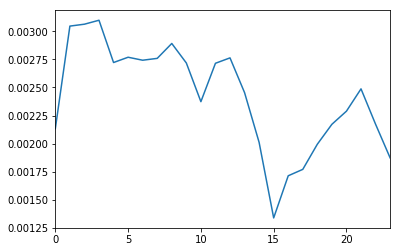

In [12]:
tmp.reset_index()[1].plot()

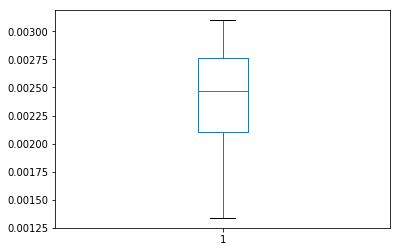

In [13]:
tmp.reset_index()[1].plot(kind = 'box')

Conversion rate in general fluctuates from 0.1% to 0.3%. Very low rate and highly unbalanced classification problem. The positive label is extremely rare.

# 3) Examination of core dimensions

It is worth investigating how our core dimensions are distributed (volume of "visits" spread over different values) in comparison to their respective conversion rate. In other words, is there a particular segment of those dimensions that converts particularly well?

Our core dimensions are:<br>
a) Operating System<br>
b) Channel (Similar to marketing channels in online analytics? Maybe)<br>
c) Device<br>
d) Application<br>

### a) Operating System

The OS dimension has decent amount of unique values but not the highest.

In [14]:
print('Unique OS values: ' + str(len(main_data.os.unique())))

Unique OS values: 673


Let's examing the conversion in relation to its volume across the different values.

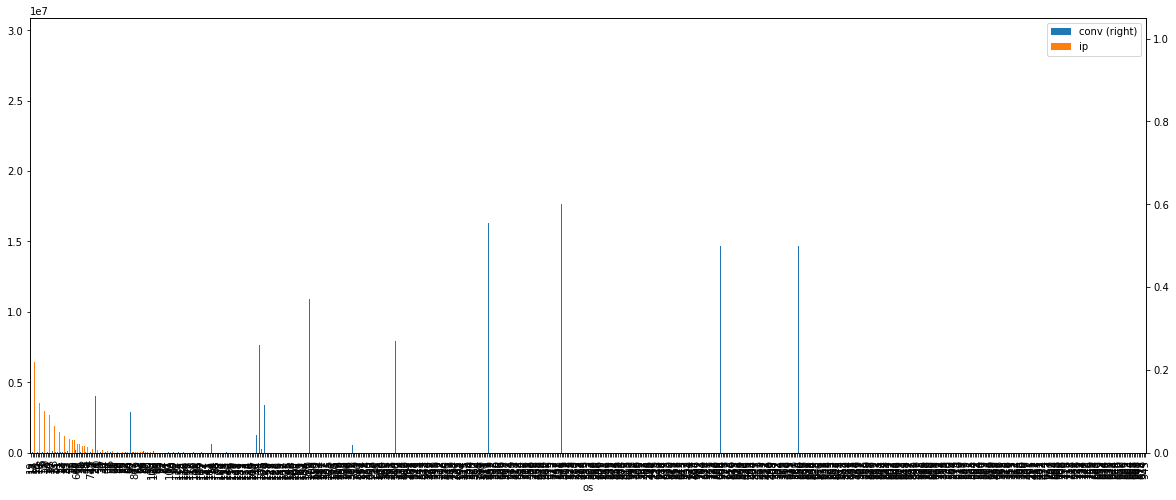

In [15]:
os_conv = print_conversion_by_dim(main_data[['os','ip','is_attributed']], dimension = 'os')

It looks like a small portion of values contain the majority of the volume. Regarding Conversion, There are some spikes here and there but nothing stands out. Let's see what happens when we inspect only OS values that display a conversion value greater than 0.

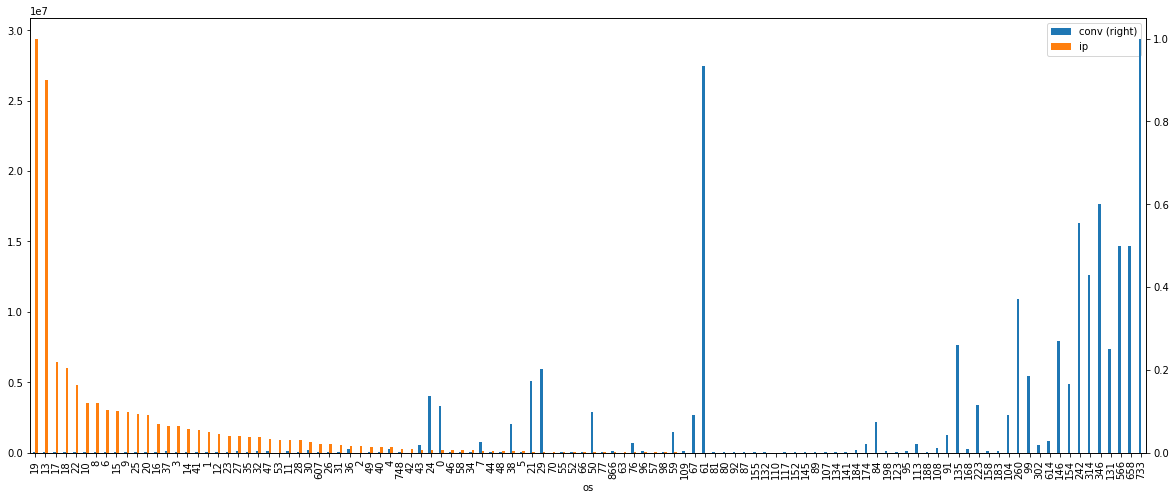

In [16]:
print_conversion_by_dim_for_converting_values(os_conv, 'os')

Now the total volume of OS values has decreased dramatically but for the high volume Operating Systems, conversion remains at small levels.

### b) Channel

Applying the same logic on Channel, we notice the same behaviour. The only difference is that there are more high volume values that have decent conversion while the total number of unique values is relatively small. That probably indicates that this dimension has bigger impact on predicting the positive outcome.

In [17]:
print('Unique Channel values: ' + str(len(main_data.channel.unique())))

Unique Channel values: 194


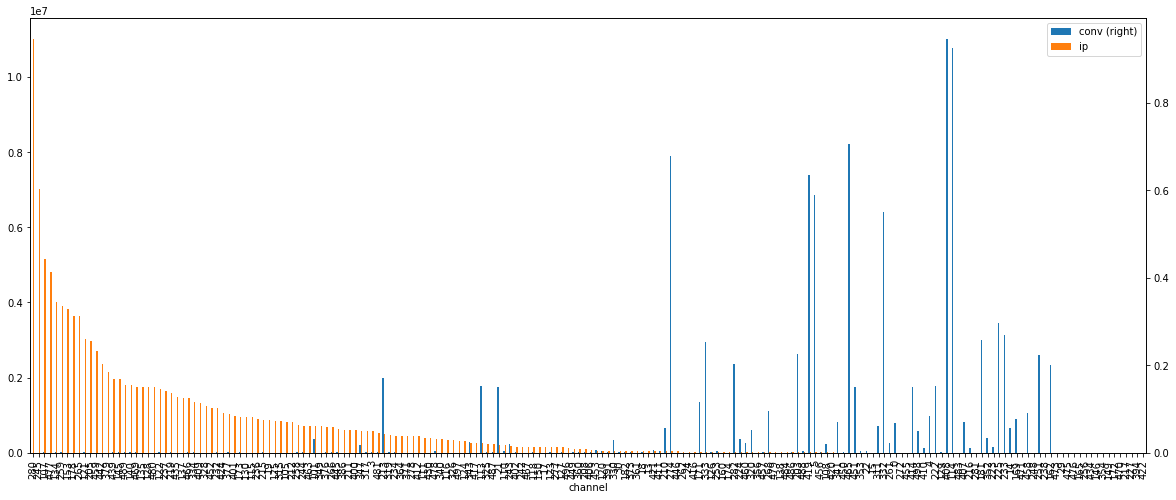

In [18]:
res = print_conversion_by_dim(main_data[['channel','ip','is_attributed']], 'channel')

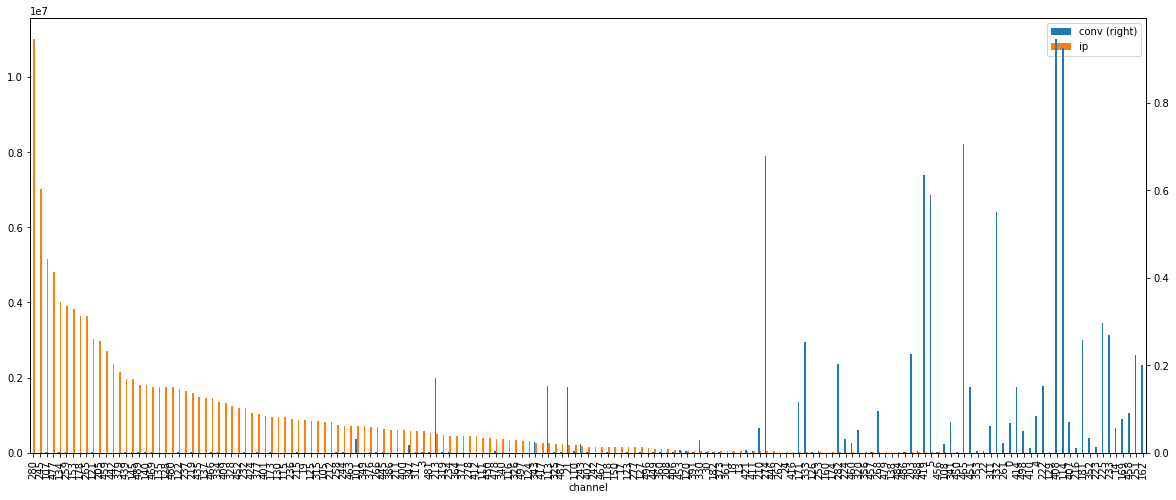

In [19]:
print_conversion_by_dim_for_converting_values(res, 'channel')

### c) Device

Device does not look as promising as the previous two dimensions. It has way more unique values and by applying the same logic as before, one can infeer that it is not a stable and reliable feature (at least for conversion).

In [20]:
print('Unique Device values: ' + str(len(main_data.device.unique())))

Unique Device values: 2928


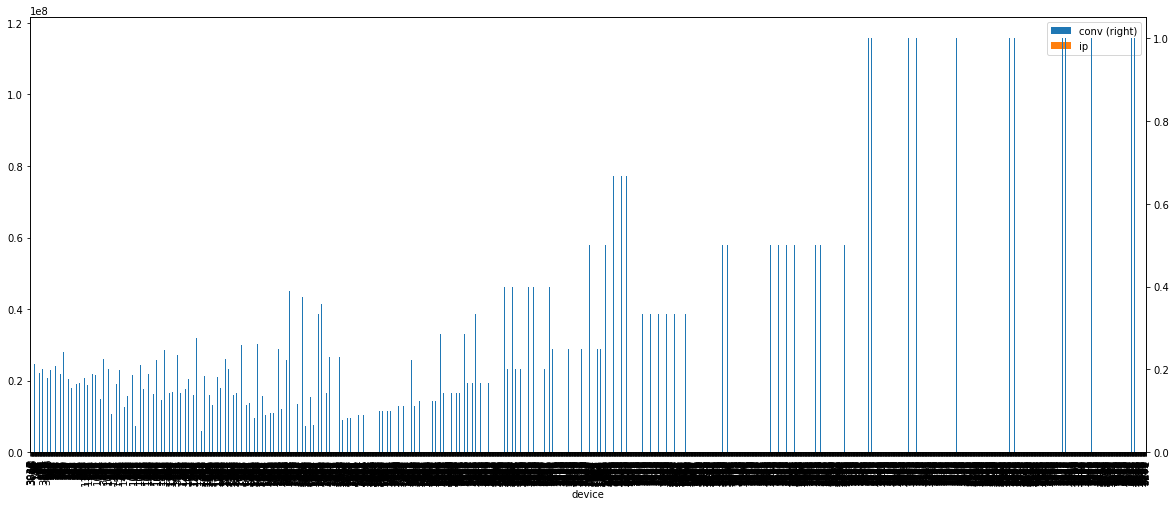

In [21]:
res = print_conversion_by_dim(main_data[['device','ip','is_attributed']], 'device')

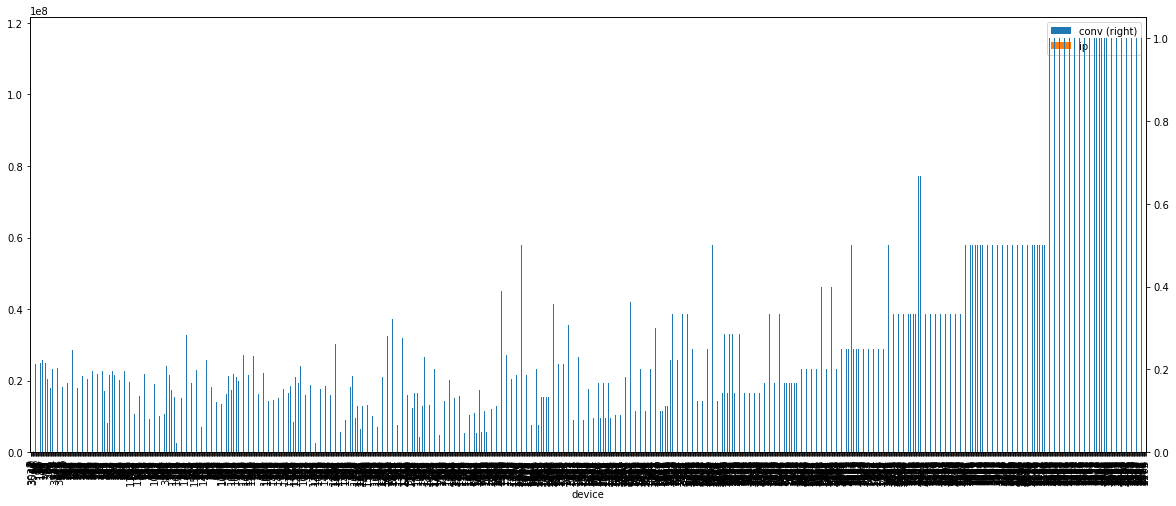

In [22]:
print_conversion_by_dim_for_converting_values(res, 'device')

### d) App

App is similar to the Operating System in terms of volume and conversion to volume alignment. So we would expect that to be affecting on similar levels the final outcome.

In [23]:
print('Unique App values: ' + str(len(main_data.app.unique())))

Unique App values: 667


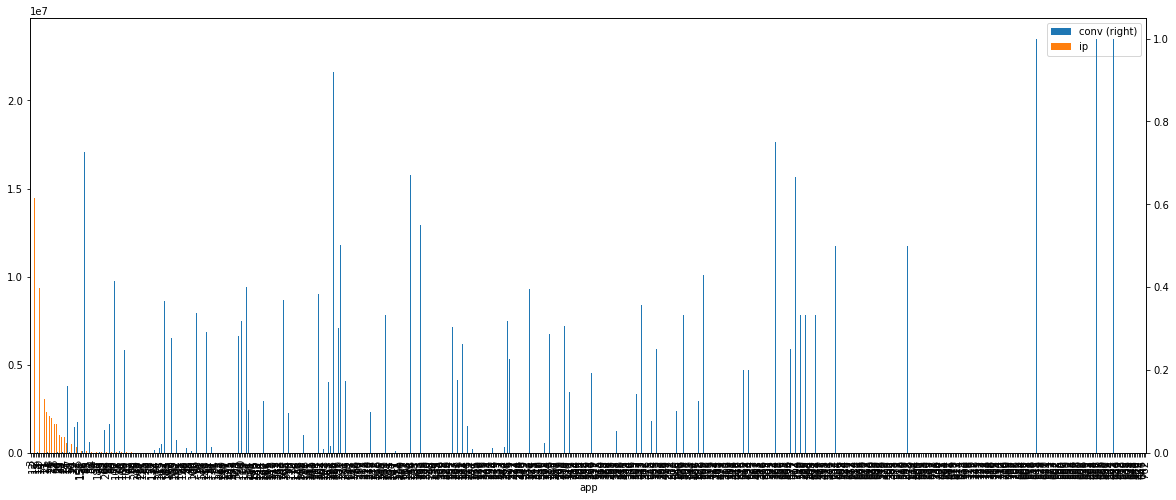

In [24]:
res = print_conversion_by_dim(main_data[['app','ip','is_attributed']], 'app')

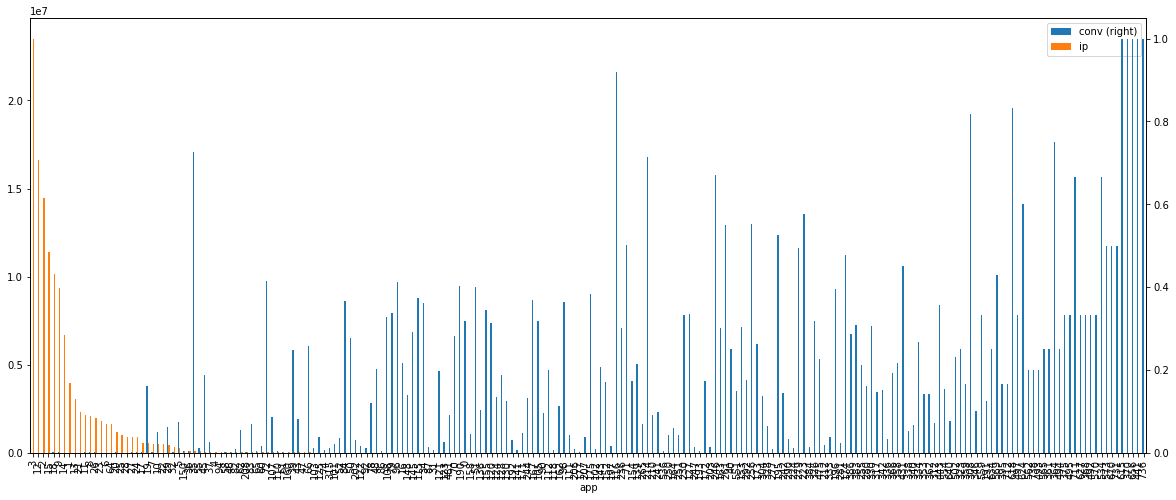

In [25]:
print_conversion_by_dim_for_converting_values(res, 'app')

# 4) Model Building

### Test set examination

Time to load the test set and do a basic review of it.

In [26]:
test_sample = pd.read_csv(main_dir + 'test.csv', dtype = data_types) 

In [27]:
test_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
click_id      uint32
ip            uint32
app           uint16
device        uint16
os            uint16
channel       uint16
click_time    object
dtypes: object(1), uint16(4), uint32(2)
memory usage: 430.1+ MB


In [28]:
test_sample = format_data(test_sample)

In [29]:
test_sample.head()

,click_id,ip,app,device,os,channel,hour,day,minute,app_instances_by_hour,device_instances_by_hour,channel_instances_by_hour,os_instances_by_hour
0,0,5744,9,1,3,107,4,10,0,475418,3175341,214877,51117
1,1,119901,9,1,3,466,4,10,0,475418,3175341,84232,51117
2,2,72287,21,1,19,128,4,10,0,77207,3175341,83619,796537
3,3,78477,15,1,13,111,4,10,0,209436,3175341,14481,698518
4,4,123080,12,1,13,328,4,10,0,396028,3175341,38063,698518


In [30]:
print(pd.crosstab(test_sample['hour'],test_sample['day']))

day        10
hour         
4     3344125
5     2858427
6         381
9     2984808
10    3127993
11        413
13    3212566
14    3261257
15        499


By inspecting the volumes of entries per hour we notice that only specific time slots have entries. We will use this later on to minimize the volume of data we use for training the algorithm. Particularly only hours 4,5,9,10,13 & 14 have significant amount of data.

### Training

Building the test and training sets for training the model. Selecting specific timeslots to make the data set smaller based on the discovery of the previous section.

In [31]:
features = ['app','device','os','channel','hour','day','minute', 'app_instances_by_hour', \
            'os_instances_by_hour', 'device_instances_by_hour',  'channel_instances_by_hour']

is_test_set_hour_slots = (
    (main_data['hour'] >= 4) & (main_data['hour'] <= 5) |
    (main_data['hour'] >= 9) & (main_data['hour'] <= 10) |
    (main_data['hour'] >= 13) & (main_data['hour'] <= 14)
)

is_train_set = (main_data['day'] == 7) & is_test_set_hour_slots

is_test_set = (main_data['day'] == 8) & is_test_set_hour_slots

In [32]:
X_train = main_data[is_train_set][features]
y_train = main_data[is_train_set]['is_attributed']

X_test = main_data[is_test_set][features]
y_test = main_data[is_test_set]['is_attributed']

del is_train_set
del is_test_set
# del main_data
gc.collect()

197

For the actual model fitting, I had to experiment for different parameters' values. There is more room for improvement here given adequate time.

In [33]:
param_min_samples_leaf = 5
param_min_samples_split = 4
param_max_depth = 10
param_max_leaf_nodes = 10
param_n_estimators = 10

In [34]:
print('Start model building')
rf_cls = RandomForestClassifier(class_weight = 'balanced', \
                                min_samples_leaf = param_min_samples_leaf, \
                                min_samples_split= param_min_samples_split, \
                                max_depth= param_max_depth, \
                                # max_leaf_nodes = param_max_leaf_nodes,\
                                # n_estimators = param_n_estimators, \
                                verbose = 0)
gc.collect()
rf_cls.fit(X_train , y_train)

Start model building


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Saving a model is always a good idea!

In [35]:
print('Start model saving')
joblib.dump(rf_cls, 'model_rf_cls-965-auc.pkl') 
print('End model saving')

Start model saving
End model saving


### Model evaluation

We need to calculate different key metrics but we will focus on the ROC curce (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) as this is used by Kaggle to rank the results.

In [36]:
predictions_proba = rf_cls.predict_proba(X_test)
print('ROC AUC : ' + str(roc_auc_score(y_test, predictions_proba[:,1])))
print('-----------------')
predictions = rf_cls.predict(X_test)
print('Accuracy ' + str(accuracy_score(y_test,predictions)))
print('Precision '+ str(precision_score(y_test,predictions)))
print('Recall ' + str(recall_score(y_test,predictions)))
print('F1-score ' + str(f1_score(y_test,predictions)))

ROC AUC : 0.964490765603
-----------------
Accuracy 0.980682914851
Precision 0.102461793966
Recall 0.86537860436
F1-score 0.18322906218


By ispecting the confusion matrix, we notice that we fail to incorectly identify nearly 6.5k instances of possitive labels. There are also 500k instances of false negatives. This initially might sound a lot. However out of total 20M negative labels that's around 2.5% of incorrectly classified negative labels. 

Also our recal value is quite decent 0.874; true positives / (true positives + false negatives).

Let's plot our ROC curve.

In [37]:
fpr, tpr, _ = roc_curve(y_test, predictions_proba[:, 1])

In [38]:
roc_auc = auc(fpr, tpr)

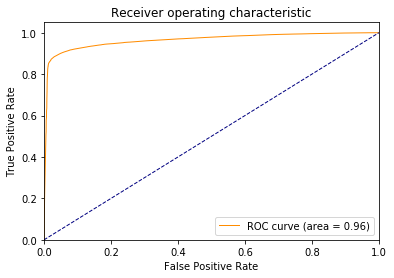

In [39]:
import matplotlib.pyplot as plt
plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',\
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [40]:
print(pd.crosstab(y_test,predictions, rownames=['Actual Value'],colnames=['Predicted Value']))

Predicted Value         0       1
Actual Value                     
0                20004912  388030
1                    6891   44297


Based on the ROC value (>0.96) along with the fact we are dealing with highly unbalanced labels, we can safely say the model is performing well on our test set.

But which features had a big impact on the results?

In [41]:
print('Feature Importance')
print('------------------')
for index in np.flip(np.argsort(rf_cls.feature_importances_, ), axis = 0):
    print(X_test.columns[index] + ' : ' + str(rf_cls.feature_importances_[index]))
print('------------------')
print('End model building')

Feature Importance
------------------
app_instances_by_hour : 0.311440660517
app : 0.247423126365
channel_instances_by_hour : 0.222245390262
os_instances_by_hour : 0.117051377151
channel : 0.0634118588414
device : 0.0205959518353
device_instances_by_hour : 0.00839140405618
os : 0.00671670110847
minute : 0.00144030918671
hour : 0.00128322067602
day : 0.0
------------------
End model building


## 5) Predictions

In [42]:
predictions = rf_cls.predict_proba(test_sample[features])
d = {'click_id': test_sample['click_id'], 'is_attributed': predictions[:,1]}
df = pd.DataFrame(data=d)
df.to_csv('output.csv', index= False)

The specific model achieves <b>0.9231350</b> on the public score. Given the small drop in AUC compared to our validation set, I would say this might have to do with the day of the week as well. For example, it might be the case that the data we use to train and validate the model are from weekdays and the test set from weekend (or vise versa).  But overall it is a good and promising result.